In [88]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

# Read data

In [89]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20231001-094426_b1fdd249c1013621872d8b8e5c0b1bf4'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [90]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Remove anomaly detection related methods

In [91]:
import numpy as np

# The example in this notebook trains an undercomplete
# autoencoder and uses it for anomaly detection.
# An anomaly is defined as an image with Gaussian noise.
# Therefore, the label is 1 if the image came from the noisy dataset.

# def combine_anomaly_dataset(clean_X: np.ndarray, noisy_X: np.ndarray) -> np.ndarray:
#     anomaly_y = np.hstack([
#         np.repeat(0, clean_X.shape[0]),  # label
#         np.repeat(1, noisy_X.shape[0]),  # label
#     ])

#     anomaly_X = np.vstack([
#         clean_X,  # data
#         noisy_X,  # data
#     ])

#     return anomaly_X, anomaly_y


# train_anomaly_X, train_anomaly_y = combine_anomaly_dataset(train_clean_X, train_noisy_X)
# validate_anomaly_X, validate_anomaly_y = combine_anomaly_dataset(validate_clean_X, validate_noisy_X)
# train_anomaly_X.shape, validate_anomaly_X.shape, train_anomaly_y.shape

In [92]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [93]:
example_id = 2

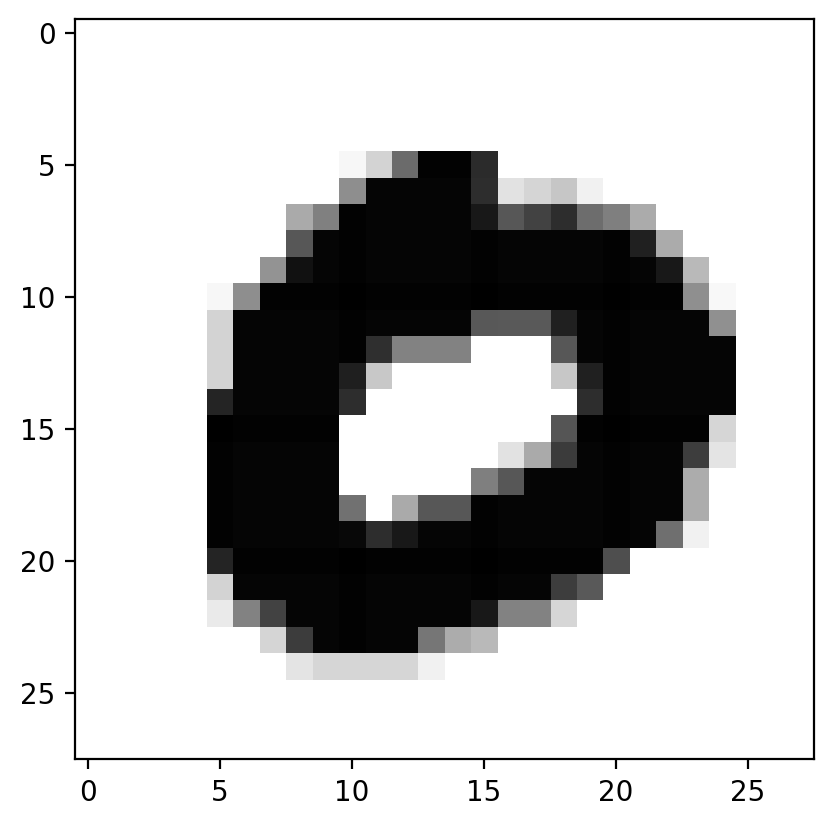

In [94]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

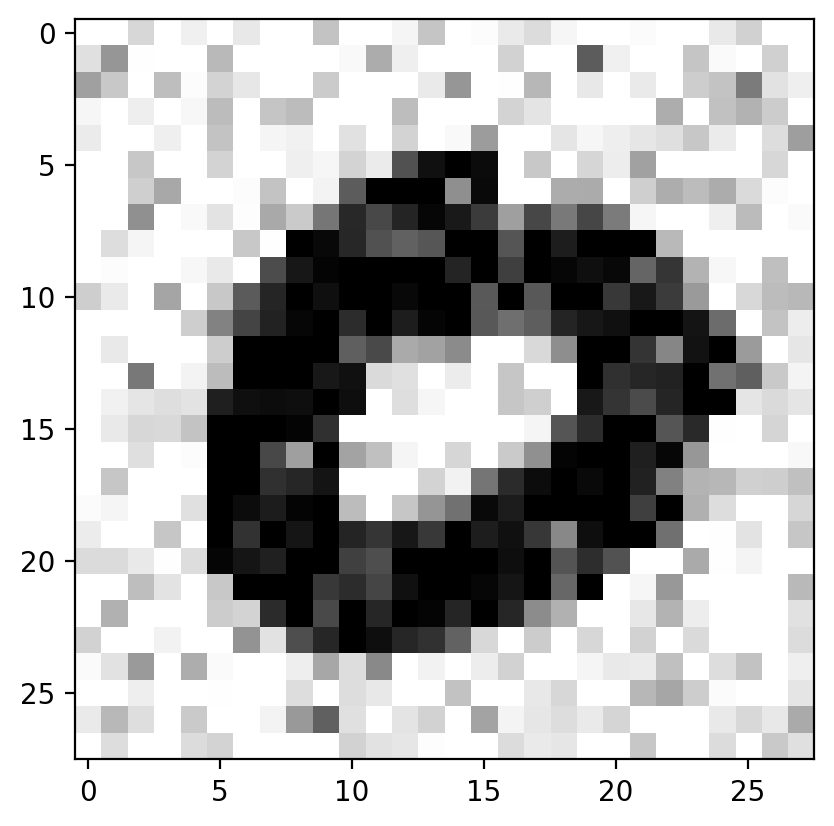

In [95]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [96]:
train_y.iloc[example_id]

digit    0
Name: 2, dtype: uint8

In [97]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Build model

In [98]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l1


def build_model(is_sparse: bool, encoder_width: int, is_learning_rate_decay: bool, learning_rate_log: float, optimizer_index: int, ) -> tf.keras.Model:
    mlflow.log_param('is_sparse', is_sparse)
    mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('is_learning_rate_decay', is_learning_rate_decay)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    mlflow.log_param('optimizer_index', optimizer_index)
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # In other words, you will probably need to tweak these lines of code.
    
    # choose between undercomplete and sparse model
    if is_sparse:
        encoder = Dense(
            units=28 * 28, 
            activity_regularizer=l1(1e-5),
            activation='gelu', 
            input_shape=(28 * 28,)
        )
    else:
        encoder = Dense(
                units=encoder_width, 
                activation='gelu', 
                input_shape=(28 * 28,)
            )
    
    decoder = Dense(units=28*28, activation='sigmoid')
    
    
    layers = [encoder, decoder]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    
    # choose optimizer and learning rate decay
    optimizer_options = [optimizers.Adam(
                learning_rate = 10 ** learning_rate_log, 
                decay = 0.004 * is_learning_rate_decay
            ), optimizers.RMSprop(
                learning_rate = 10 ** learning_rate_log, 
                decay = 0.004 * is_learning_rate_decay
            ), optimizers.SGD(
                learning_rate = 10 ** learning_rate_log, 
                decay = 0.004 * is_learning_rate_decay)]
        
    autoencoder.compile(
            optimizer=optimizer_options[optimizer_index], 
            loss='mean_squared_error',
        )
    return autoencoder

In [99]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

In [100]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.
from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_denoising_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,
       
        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X),
        callbacks=[MlflowCallback()],
        verbose=verbose
    )
    
    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [101]:
# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
mlflow.set_experiment('assignment_01')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [102]:
mlflow.get_experiment_by_name('assignment_01')

<Experiment: artifact_location='file:///app/mlflow/544734839123143668', creation_time=1696716101532, experiment_id='544734839123143668', last_update_time=1696716101532, lifecycle_stage='active', name='assignment_01', tags={}>

In [103]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

# np.random.seed(11)
# tf.random.set_seed(11)

# with mlflow.start_run():
#     autoencoder = build_model(is_sparse=True, encoder_width=10, is_learning_rate_decay=True, 
#                               learning_rate_log=-0.01, optimizer_index=1)
#     history = train_denoising_model(autoencoder, epochs=10)

# Tune Hhperparameters

## Random strategy

In [104]:
import random
import tqdm
np.random.seed(11)
tf.random.set_seed(11)

runs = 20
# Randomly generate different parameters
is_sparses = [random.choice([True, False]) for _ in range(runs)]
encoder_widths = [random.choice(range(5, 20, 5)) for _ in range(runs)]
is_decays = [random.choice([True, False]) for _ in range(runs)]
learning_rate_logs = [random.uniform(-5, 0) for _ in range(runs)]
optimizer_indices = [random.choice([0, 1, 2]) for _ in range(runs)]


parameters = list(zip(is_sparses, encoder_widths, is_decays,learning_rate_logs, optimizer_indices))
historys = []
for (is_sparse, encoder_width, is_decay, learning_rate_log, optimizer_index) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        autoencoder = build_model(is_sparse=is_sparse, encoder_width=encoder_width, 
                                  is_learning_rate_decay = is_decay, learning_rate_log=learning_rate_log,
                                 optimizer_index = optimizer_index)
        history = train_denoising_model(autoencoder, epochs=20, verbose=0)
        historys.append(history)

100%|██████████| 20/20 [05:43<00:00, 17.18s/it]


In [105]:
# Best run
best_run = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name('assignment_01').experiment_id, 
                             order_by=['metric.mean_squared_error ASC']).iloc[0]


saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(best_run['run_id'], 'model')
autoencoder = load_model(saved_model_path)

In [ ]:
# # This loads the last active run,
# # but you probably want to load the best run from the experiment.
# last_run = mlflow.last_active_run()
# saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(last_run.info.run_id, 'model')
# autoencoder = load_model(saved_model_path)

## Check hyperparameters

In [113]:
from sklearn.metrics import mean_squared_error
train_denoised_X = autoencoder.predict(train_noisy_X)
train_denoised_X = pd.DataFrame(train_denoised_X)


mean_squared_error(train_denoised_X, train_clean_X)

0.009095622

In [114]:
validate_denoised_X = autoencoder.predict(validate_noisy_X)
validate_denoised_X = pd.DataFrame(validate_denoised_X)


mean_squared_error(validate_denoised_X, validate_clean_X)

0.009592801

## Check learning curve

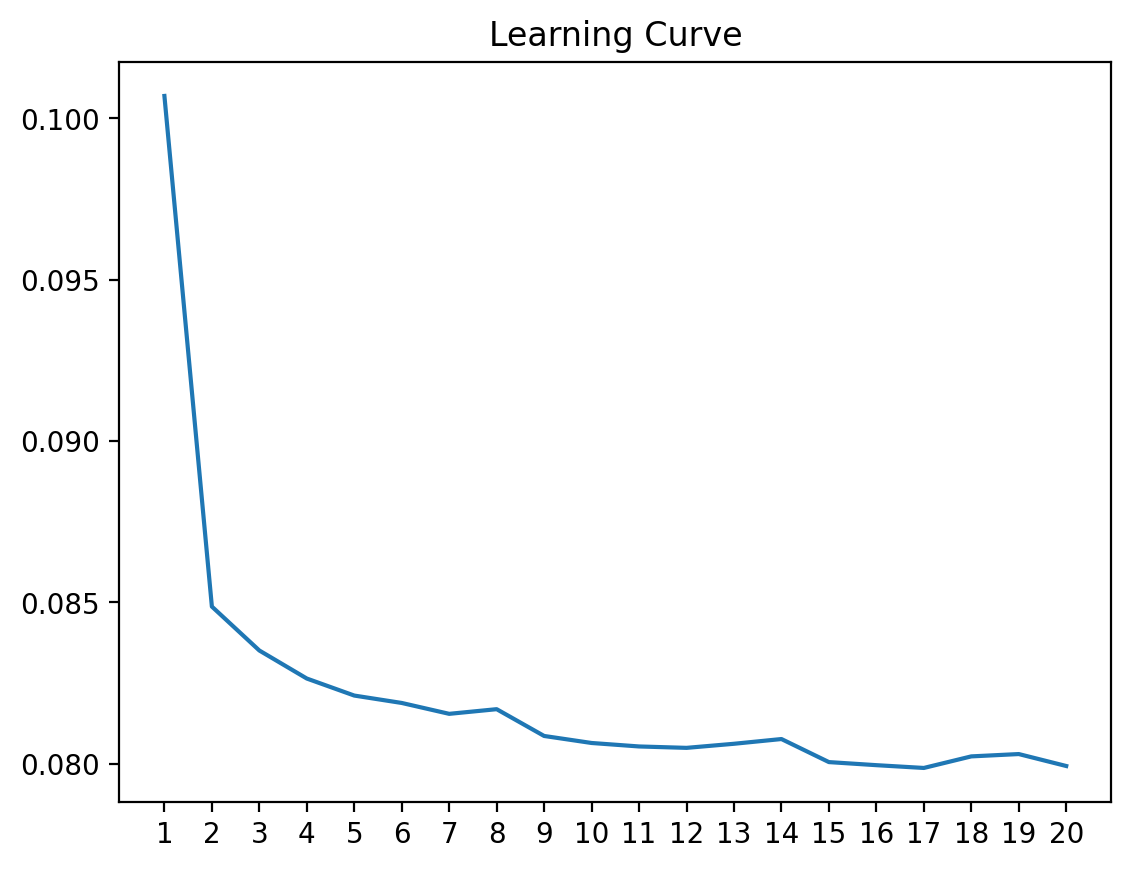

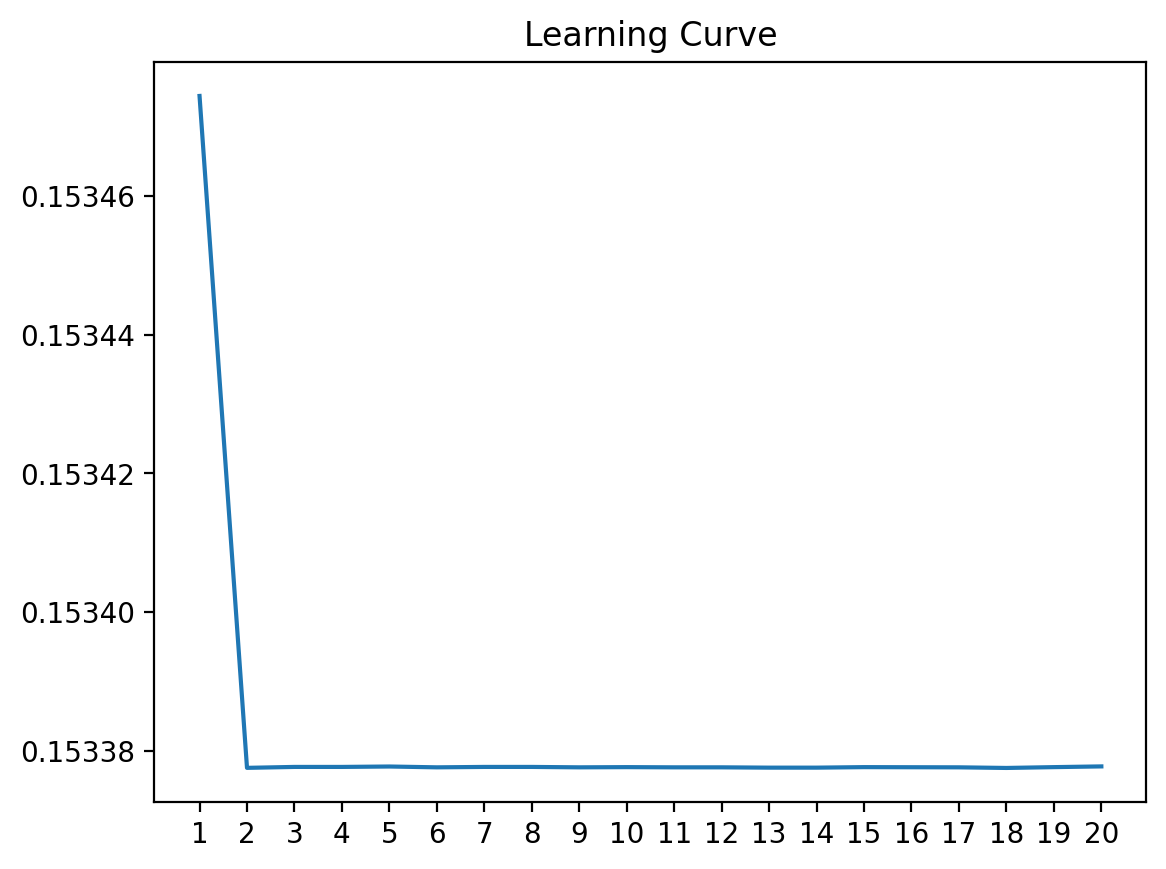

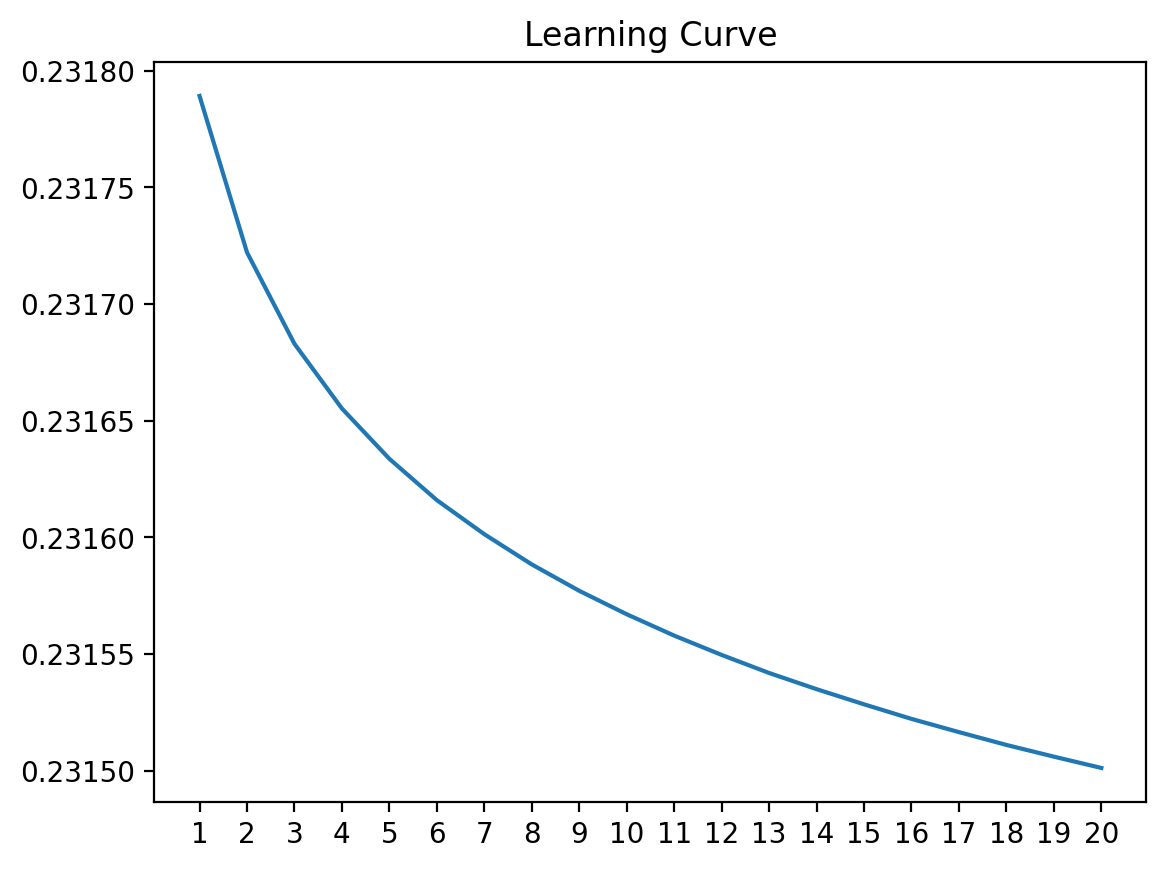

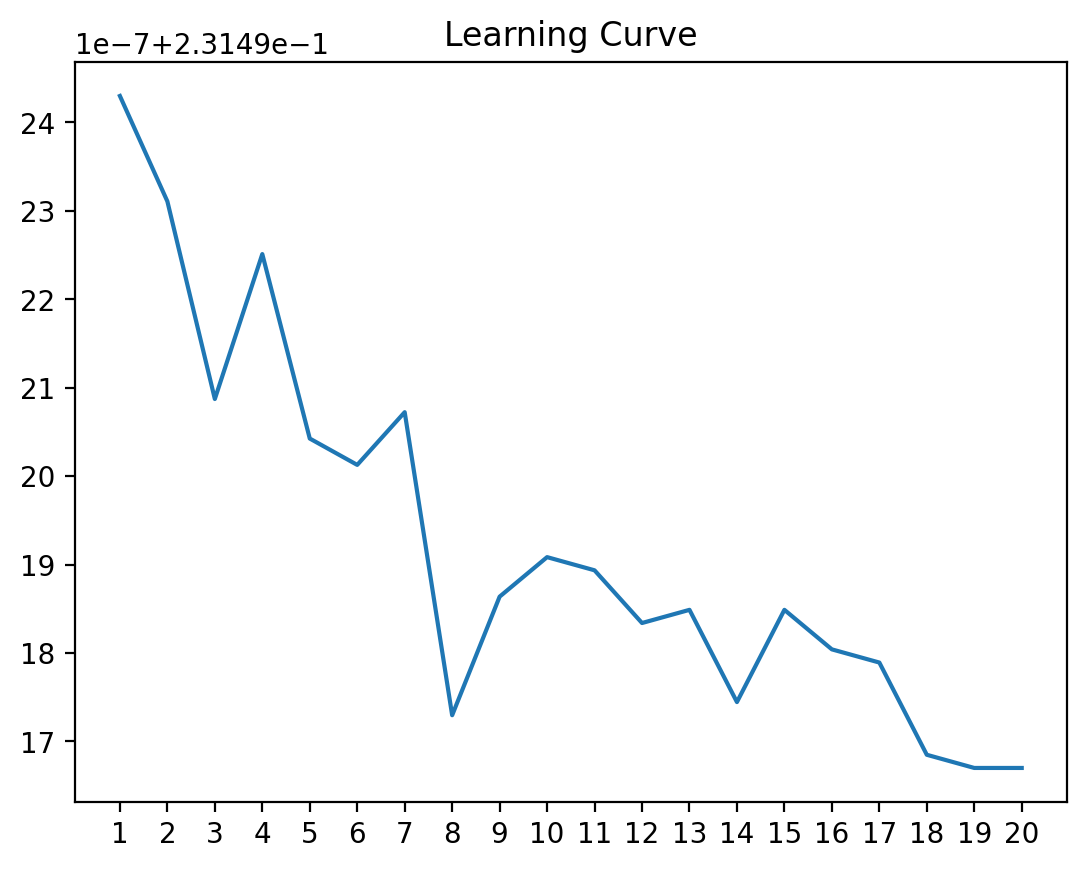

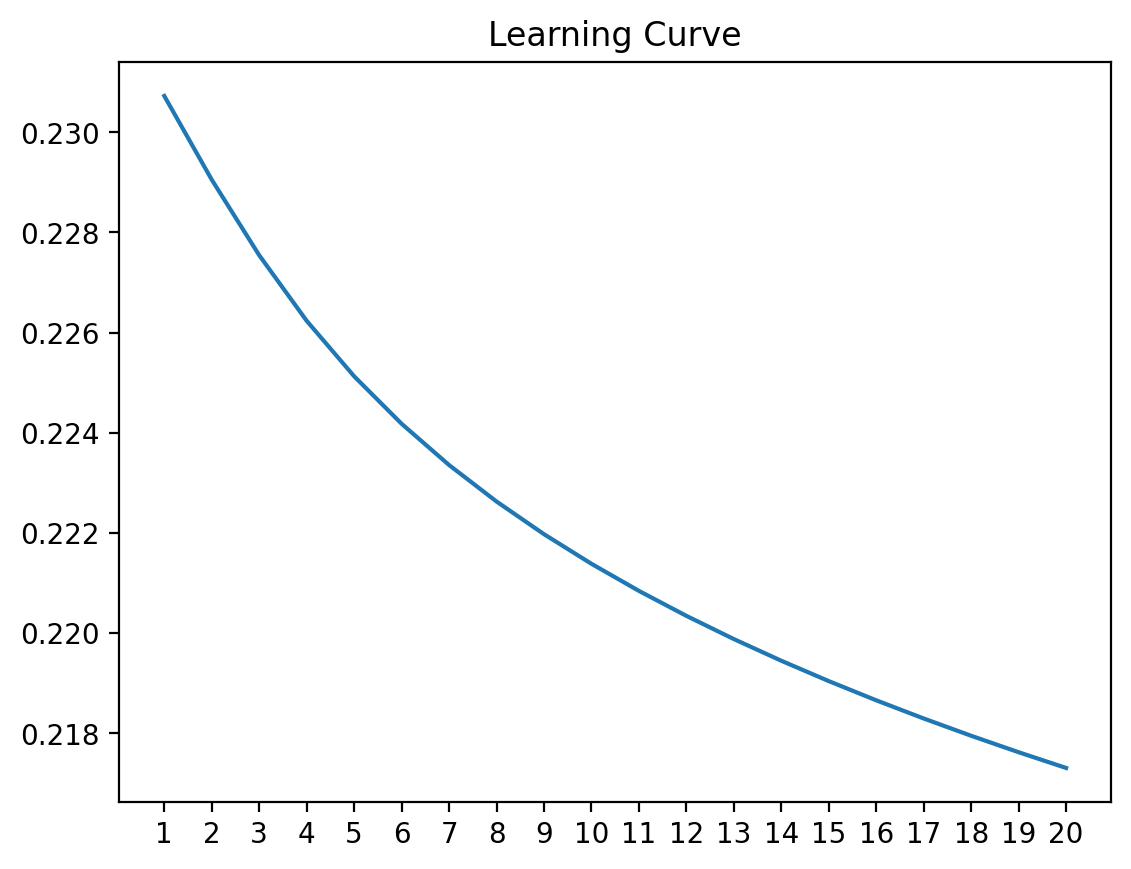

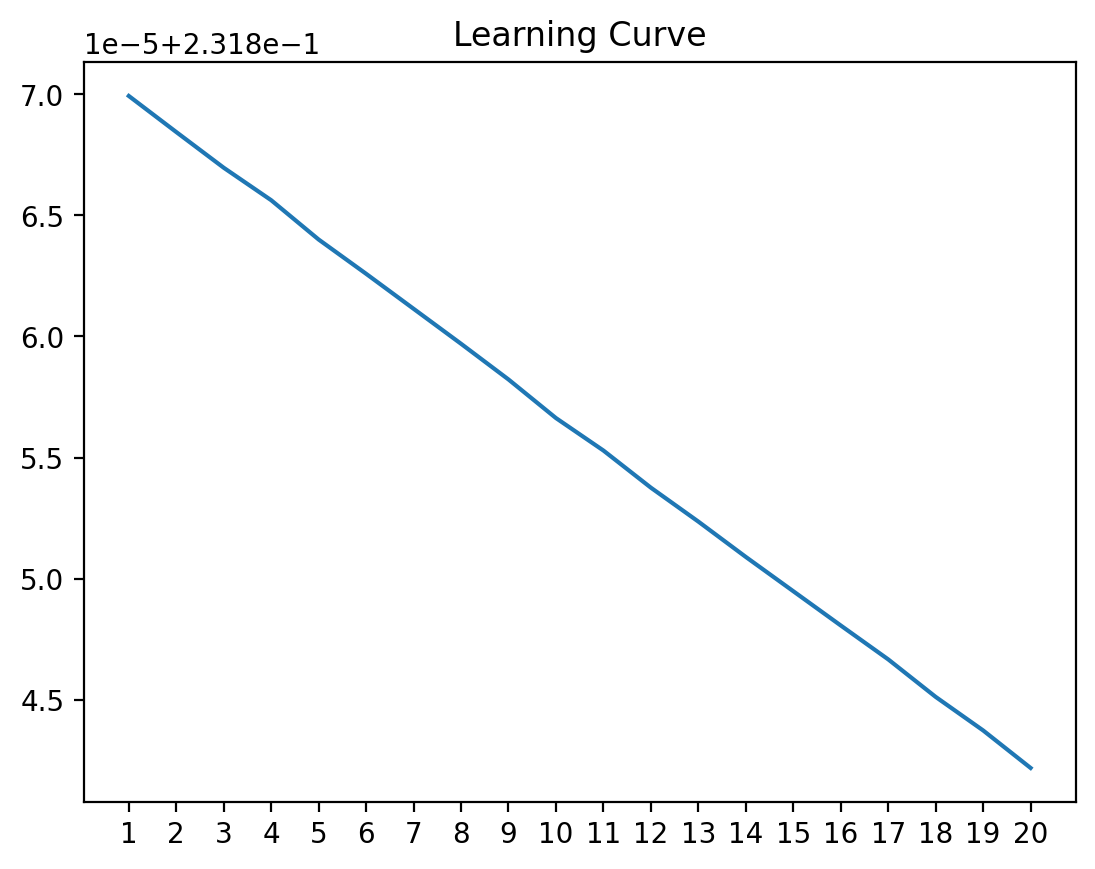

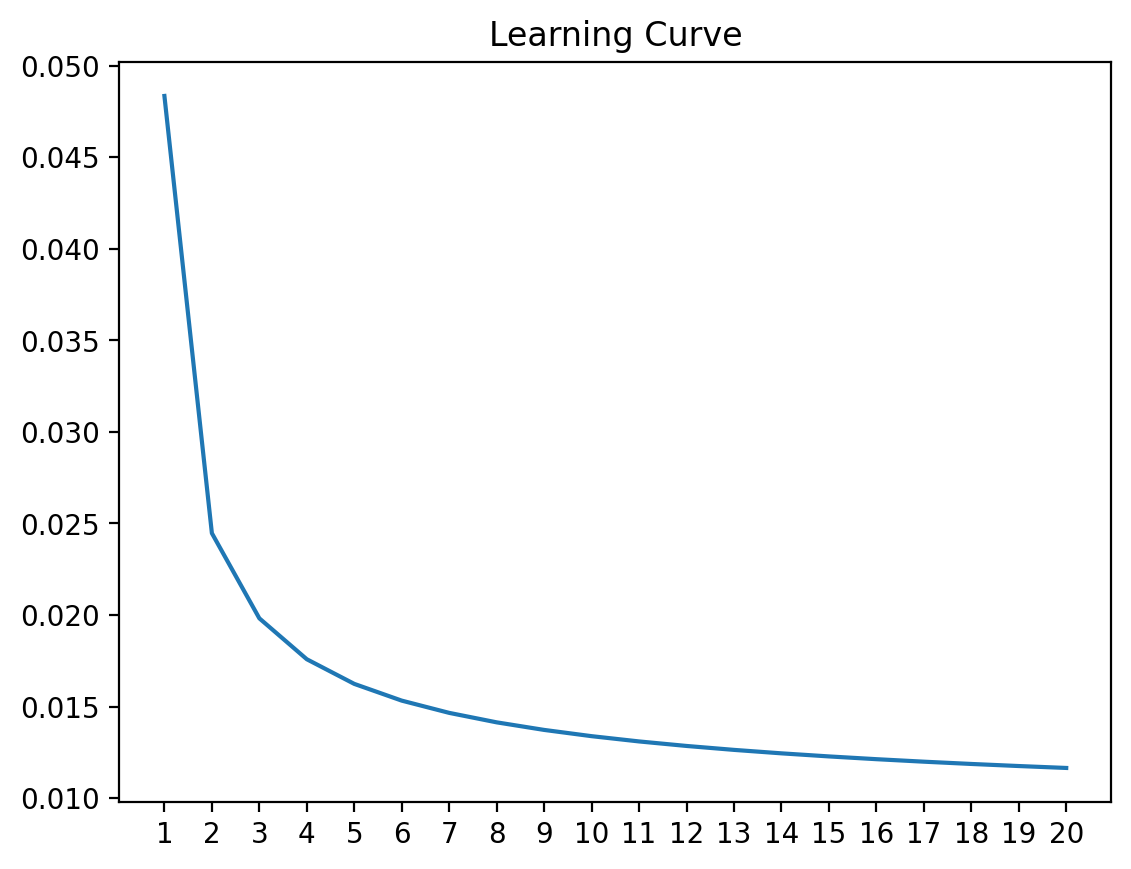

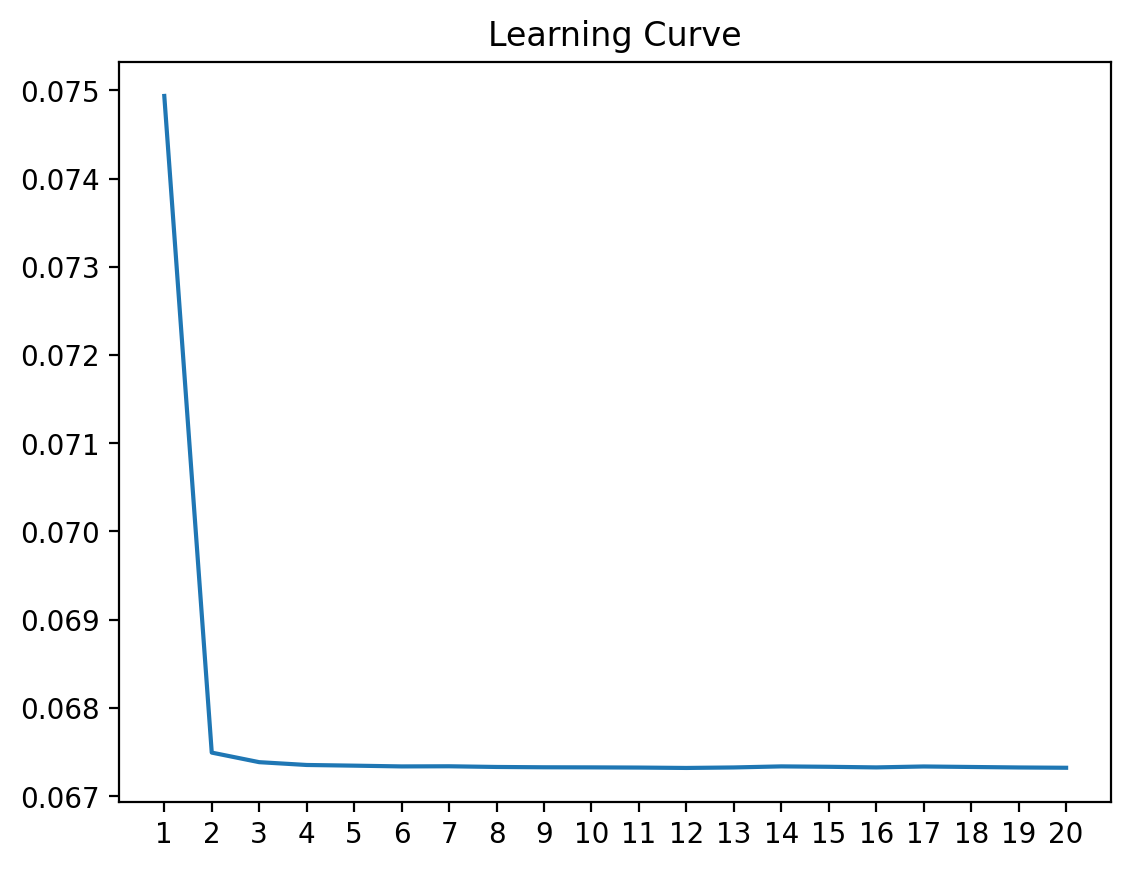

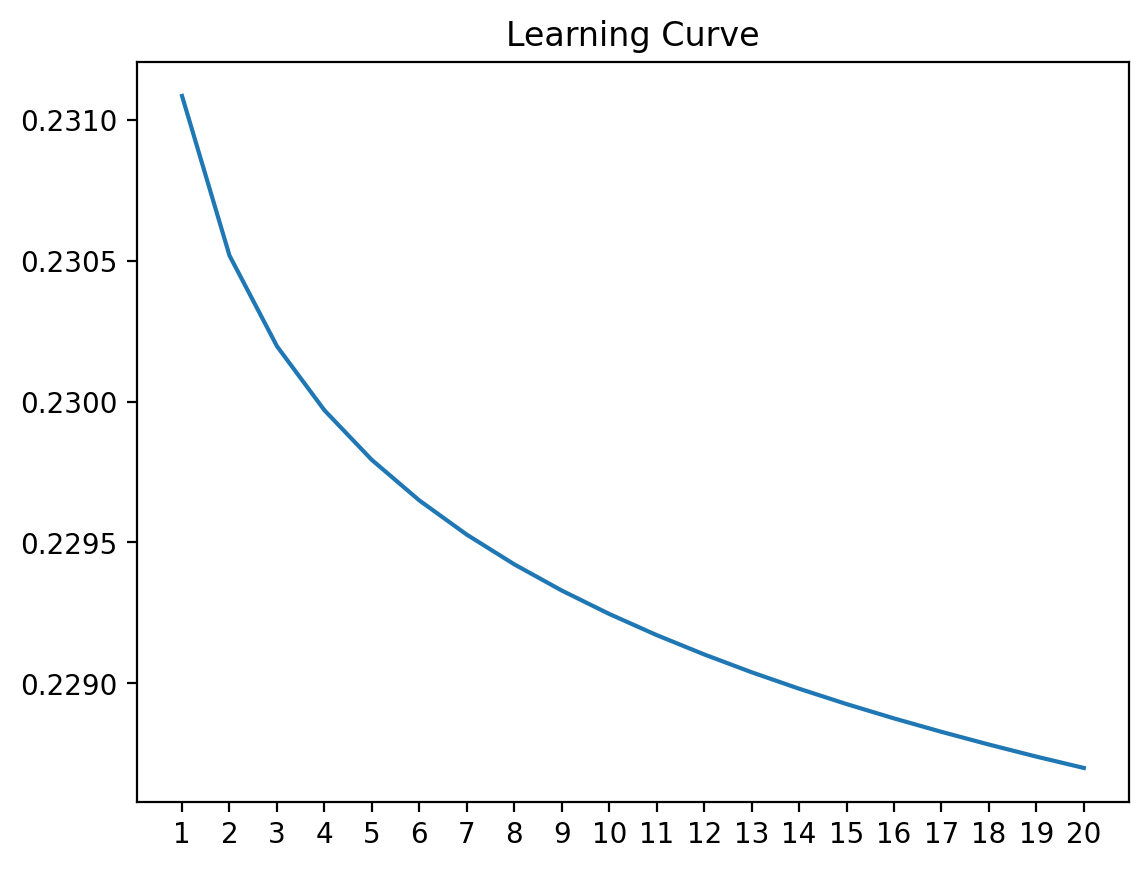

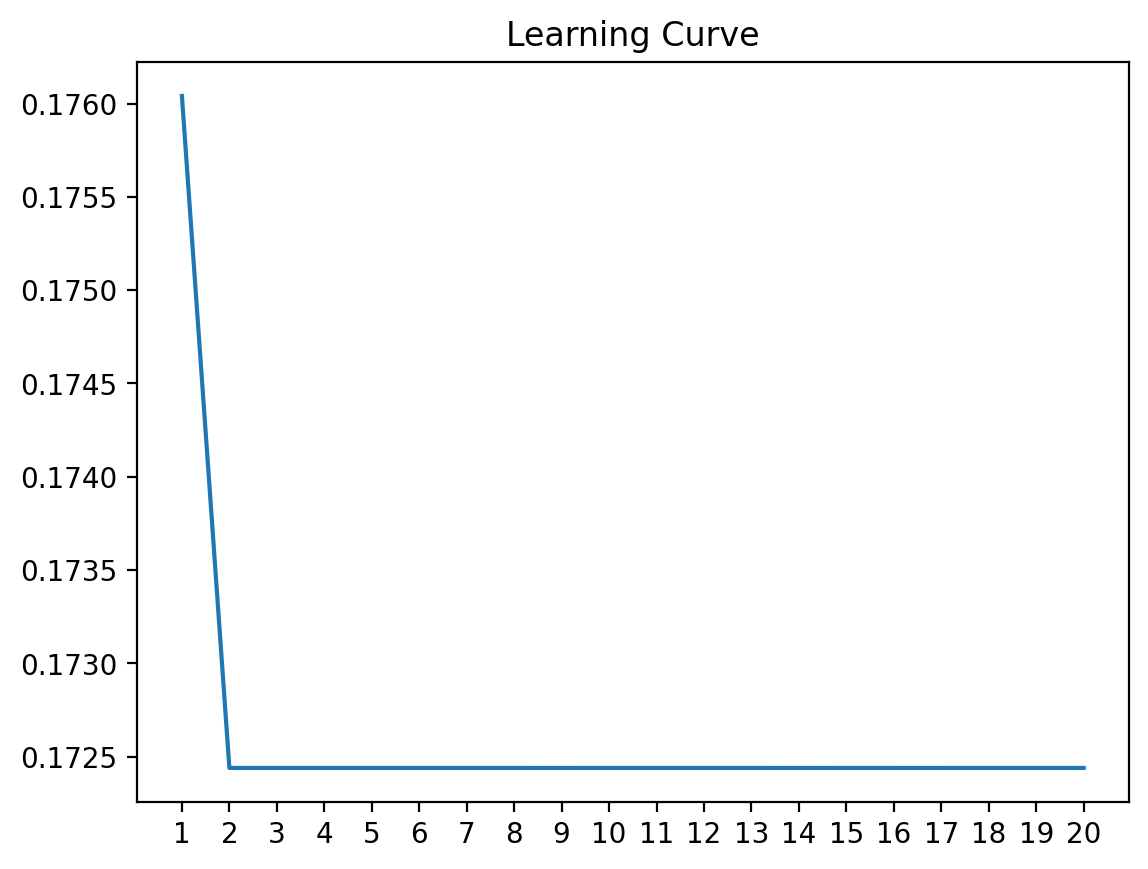

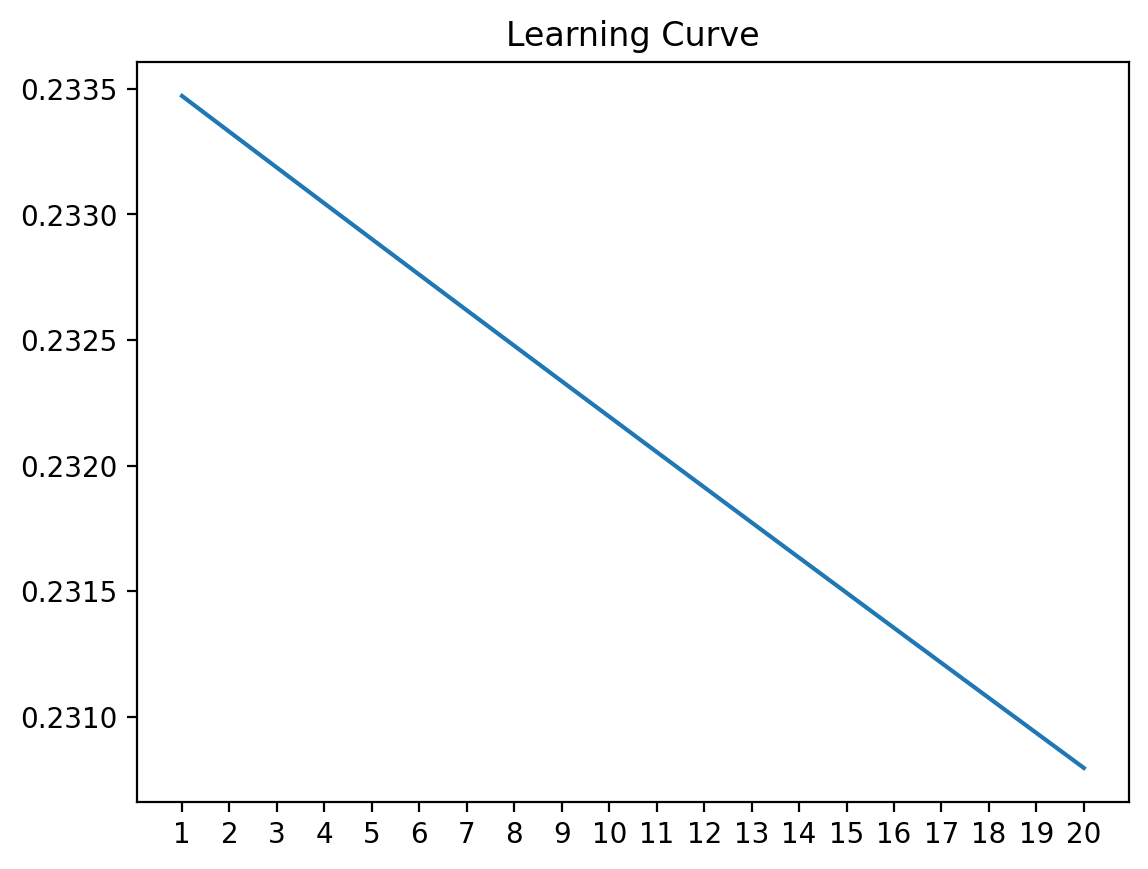

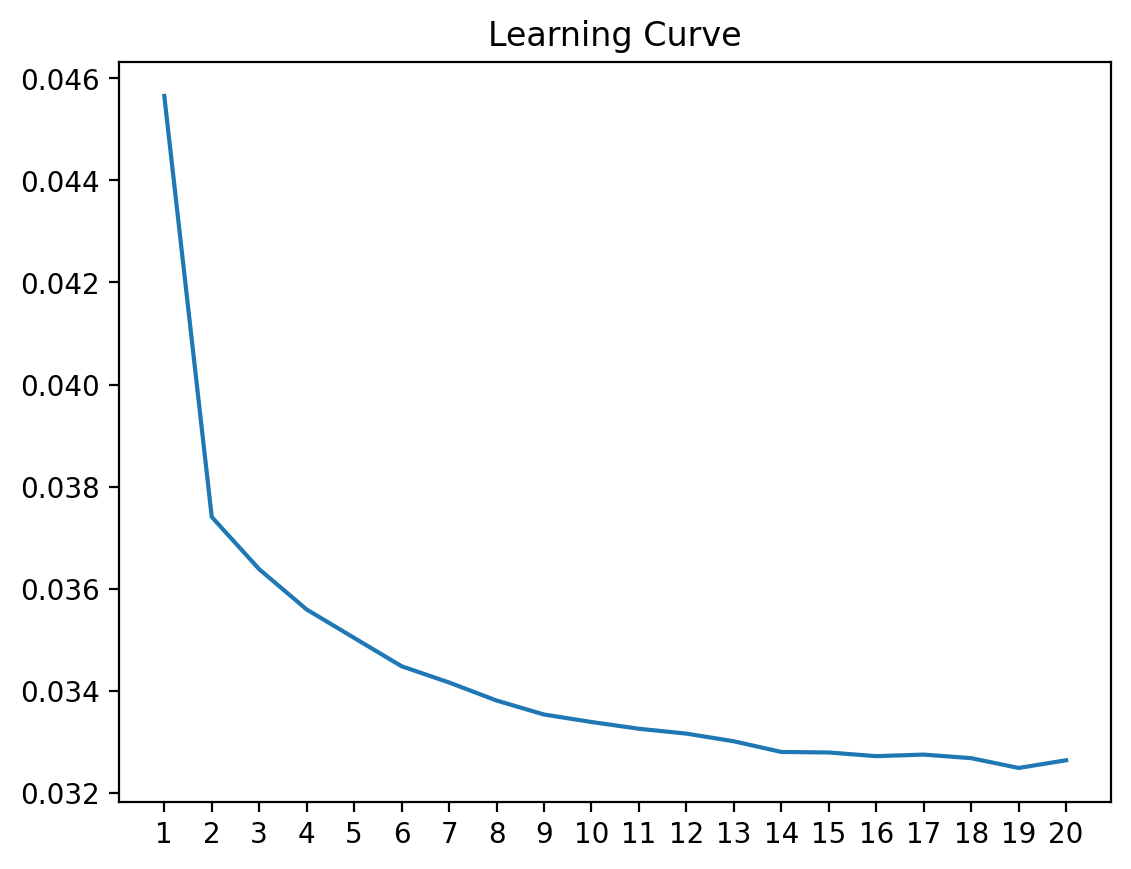

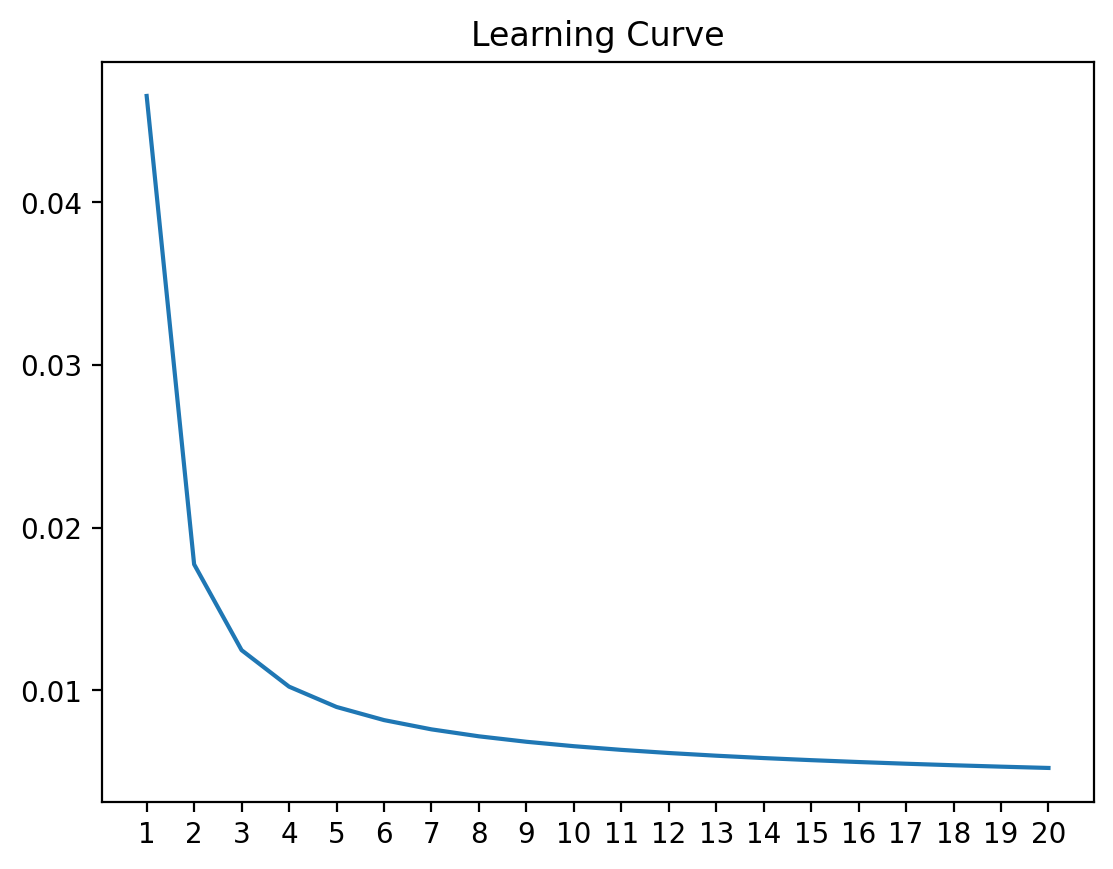

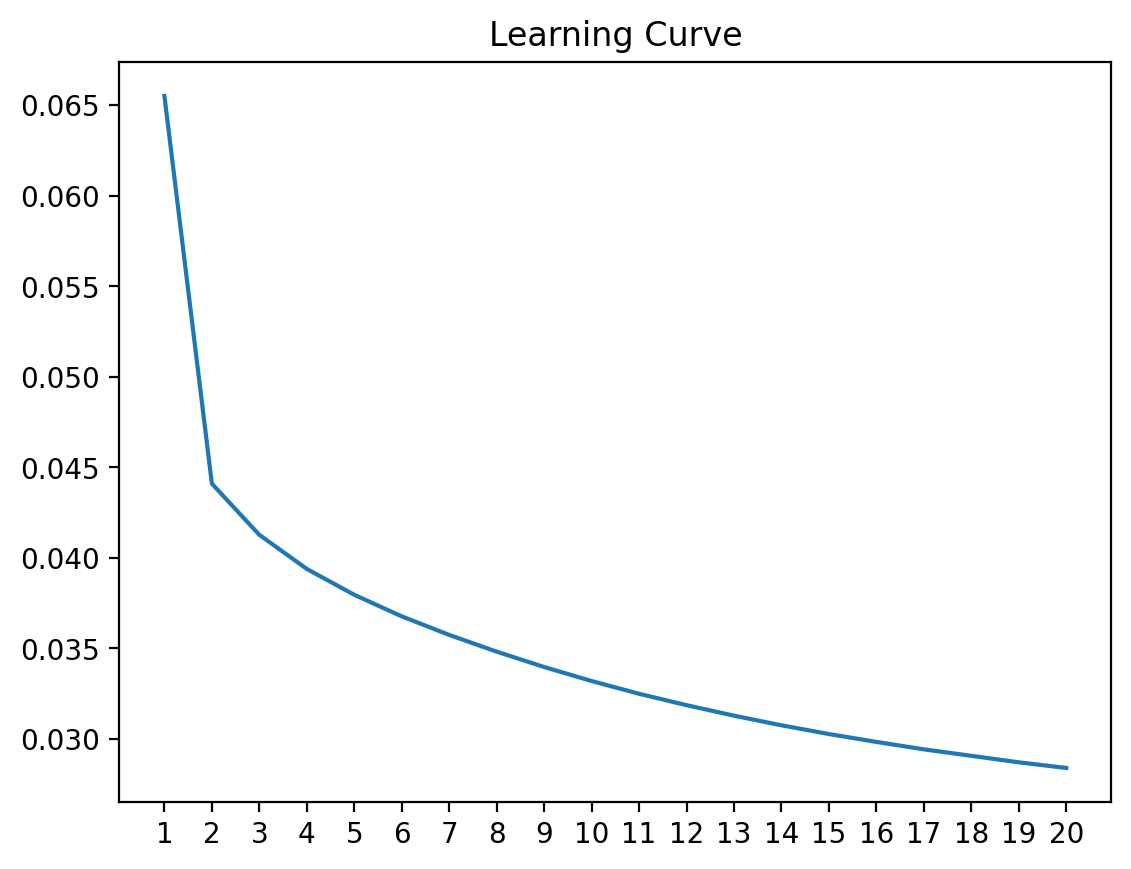

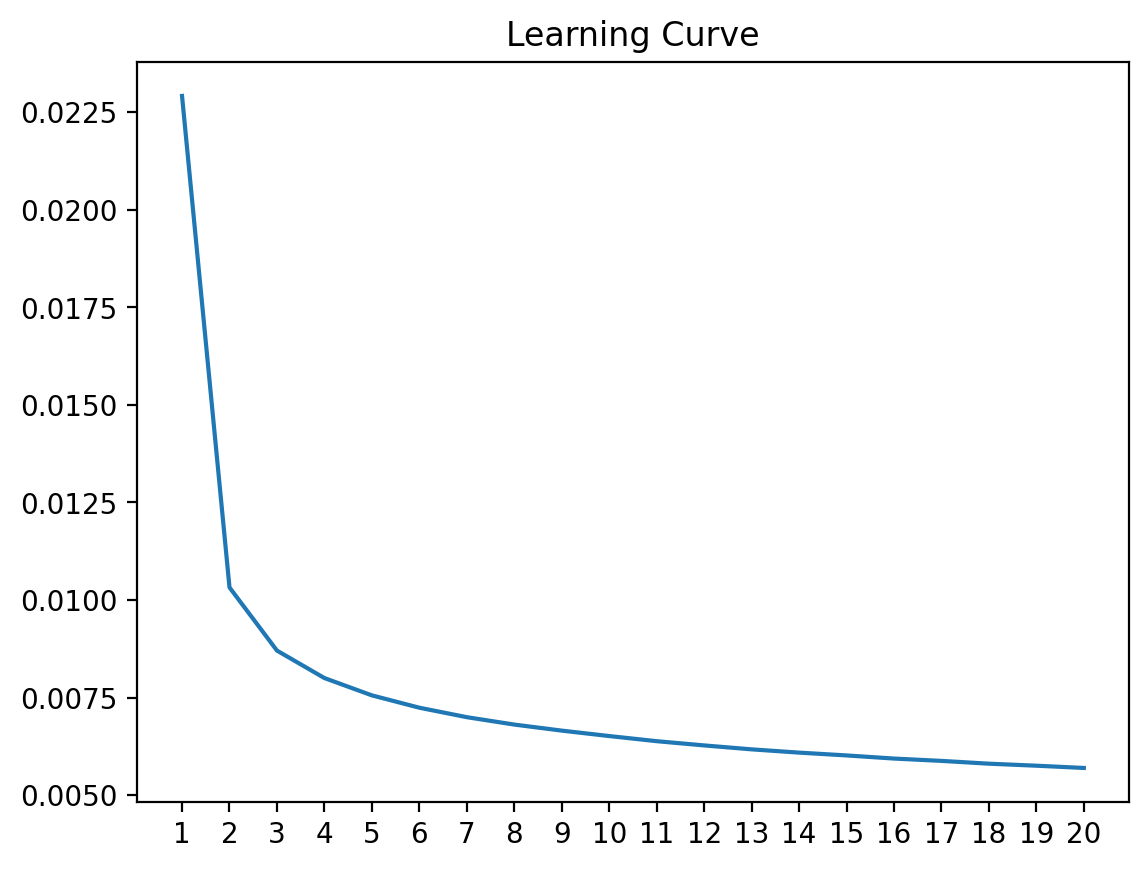

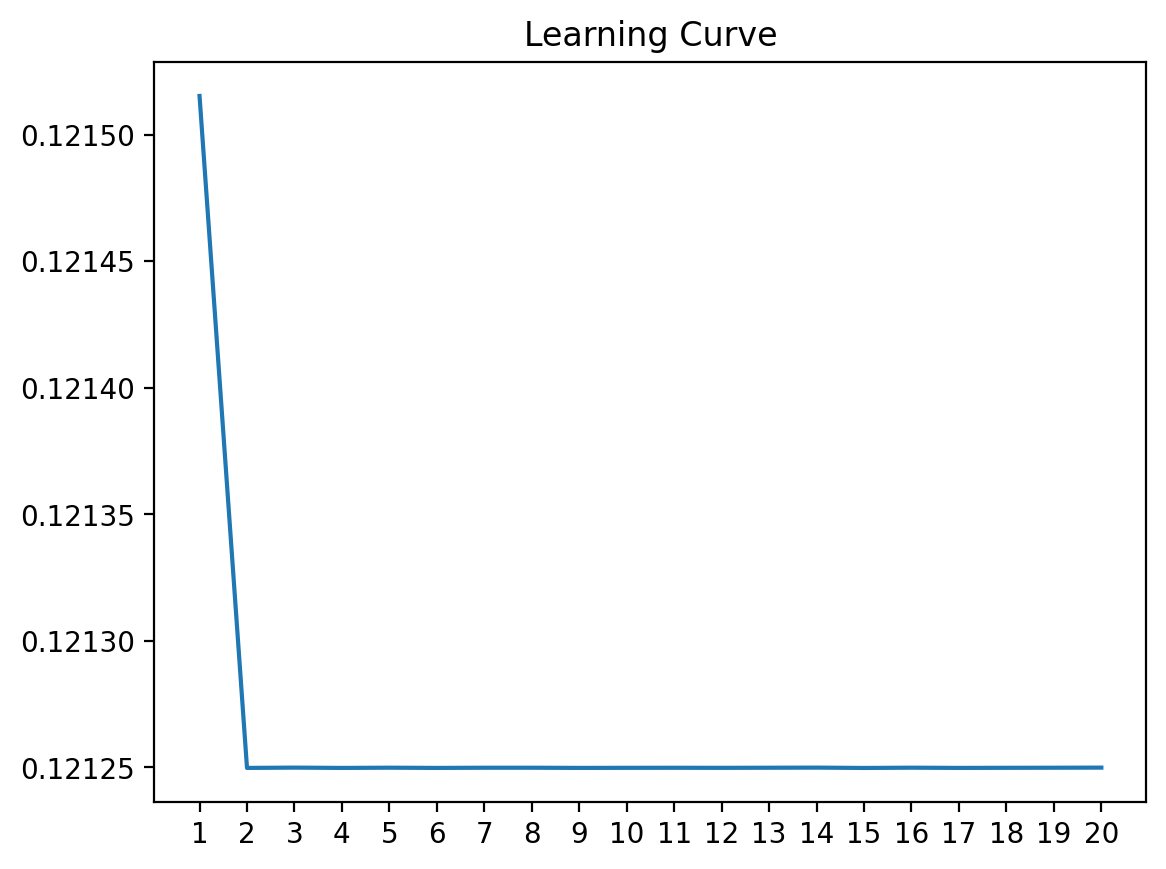

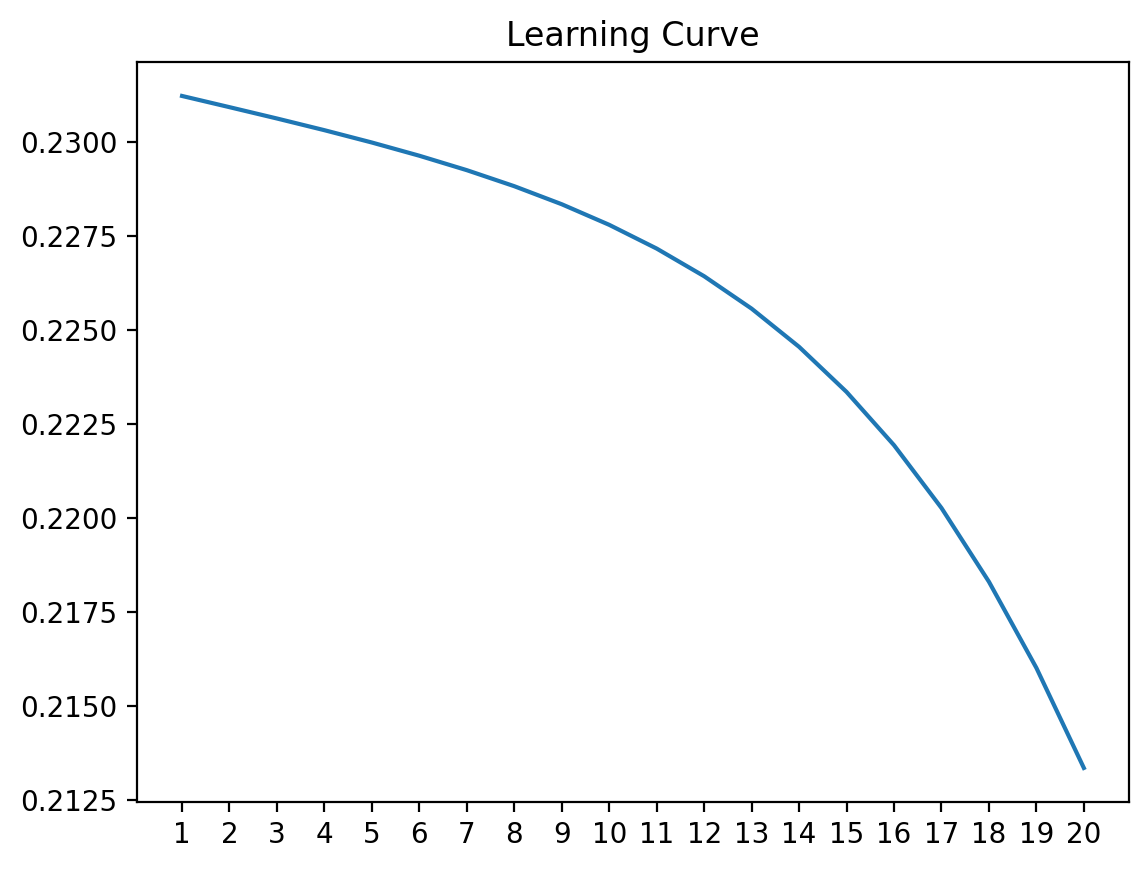

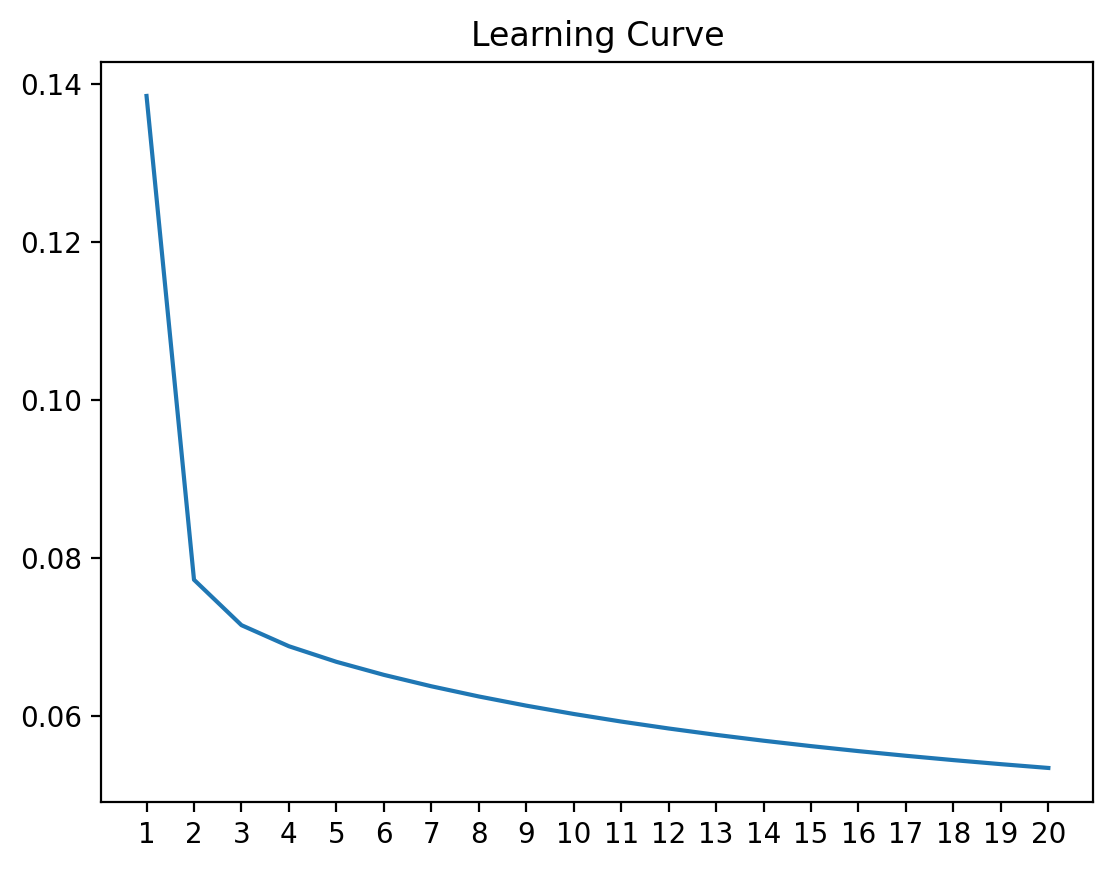

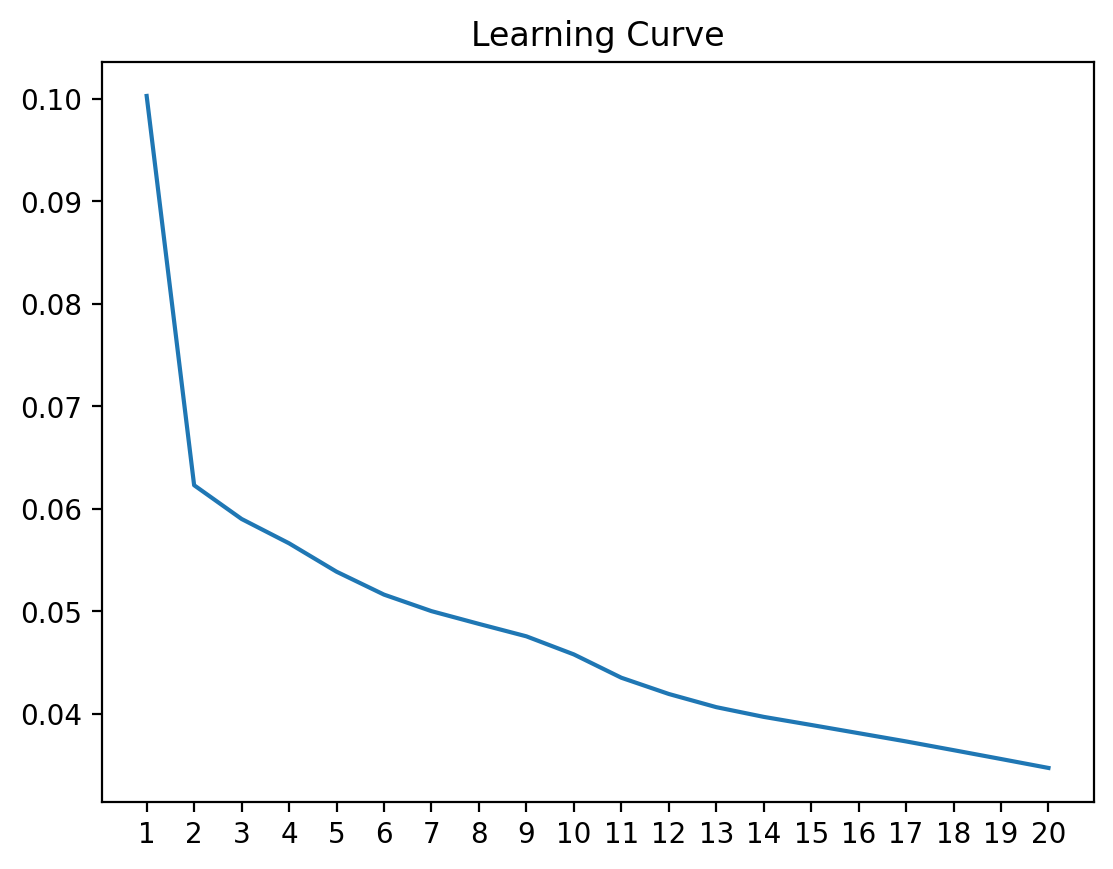

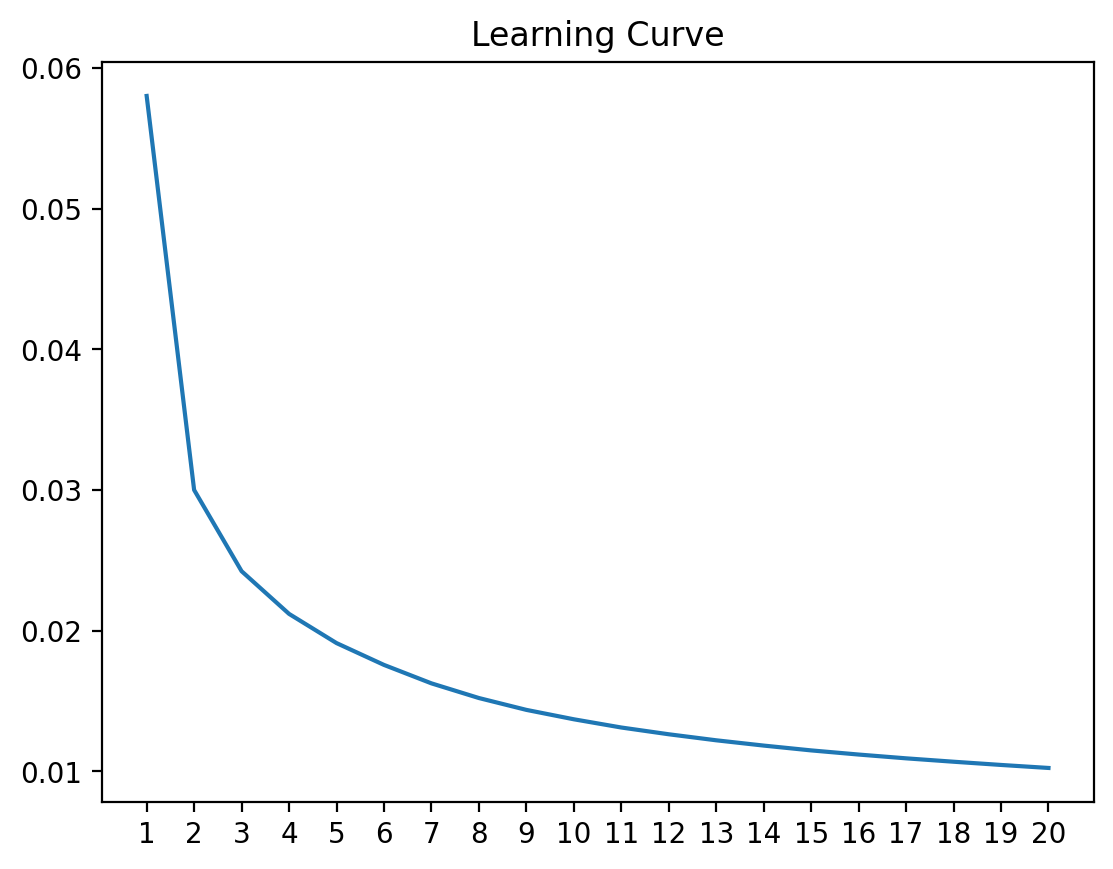

In [115]:
for history in historys:
    plot_learning_curve(history)

# Fine tune the model

In [116]:
np.random.seed(11)
tf.random.set_seed(11)

with mlflow.start_run():
    # autoencoder = build_model(is_sparse=True, encoder_width=10, is_learning_rate_decay=True, 
                              # learning_rate_log=-0.01, optimizer_index=1)
    history = train_denoising_model(autoencoder, epochs=500)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [117]:
train_denoised_X = autoencoder.predict(train_noisy_X)
train_denoised_X = pd.DataFrame(train_denoised_X)


mean_squared_error(train_denoised_X, train_clean_X)

0.00457959

In [122]:
validate_denoised_X = autoencoder.predict(validate_noisy_X)
validate_denoised_X = pd.DataFrame(validate_denoised_X)


mean_squared_error(validate_denoised_X, validate_clean_X)

0.0049603614

In [118]:
test_denoised_X = autoencoder.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)


mean_squared_error(test_denoised_X, test_clean_X)

0.004891278

## Plot digits

In [119]:
def plot_check(example_id, clean_X, noisy_X, predicted_X):
    image_pixels_clean = clean_X.iloc[example_id]
    image_pixels_noisy = noisy_X.iloc[example_id]
    image_pixels_predicted = predicted_X.iloc[example_id]
    
    image_pixels_clean = image_pixels_clean.values.reshape(28, 28)
    image_pixels_noisy = image_pixels_noisy.values.reshape(28, 28)
    image_pixels_predicted = image_pixels_predicted.values.reshape(28, 28)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the clean image
    axes[0].set_title("Clean Image")
    axes[0].imshow(image_pixels_clean, cmap='binary')

    # Plot the noisy image
    axes[1].set_title("Noisy Image")
    axes[1].imshow(image_pixels_noisy, cmap='binary')

    # Plot the predicted image
    axes[2].set_title("Denoised Image")
    axes[2].imshow(image_pixels_predicted, cmap='binary')

    plt.show()


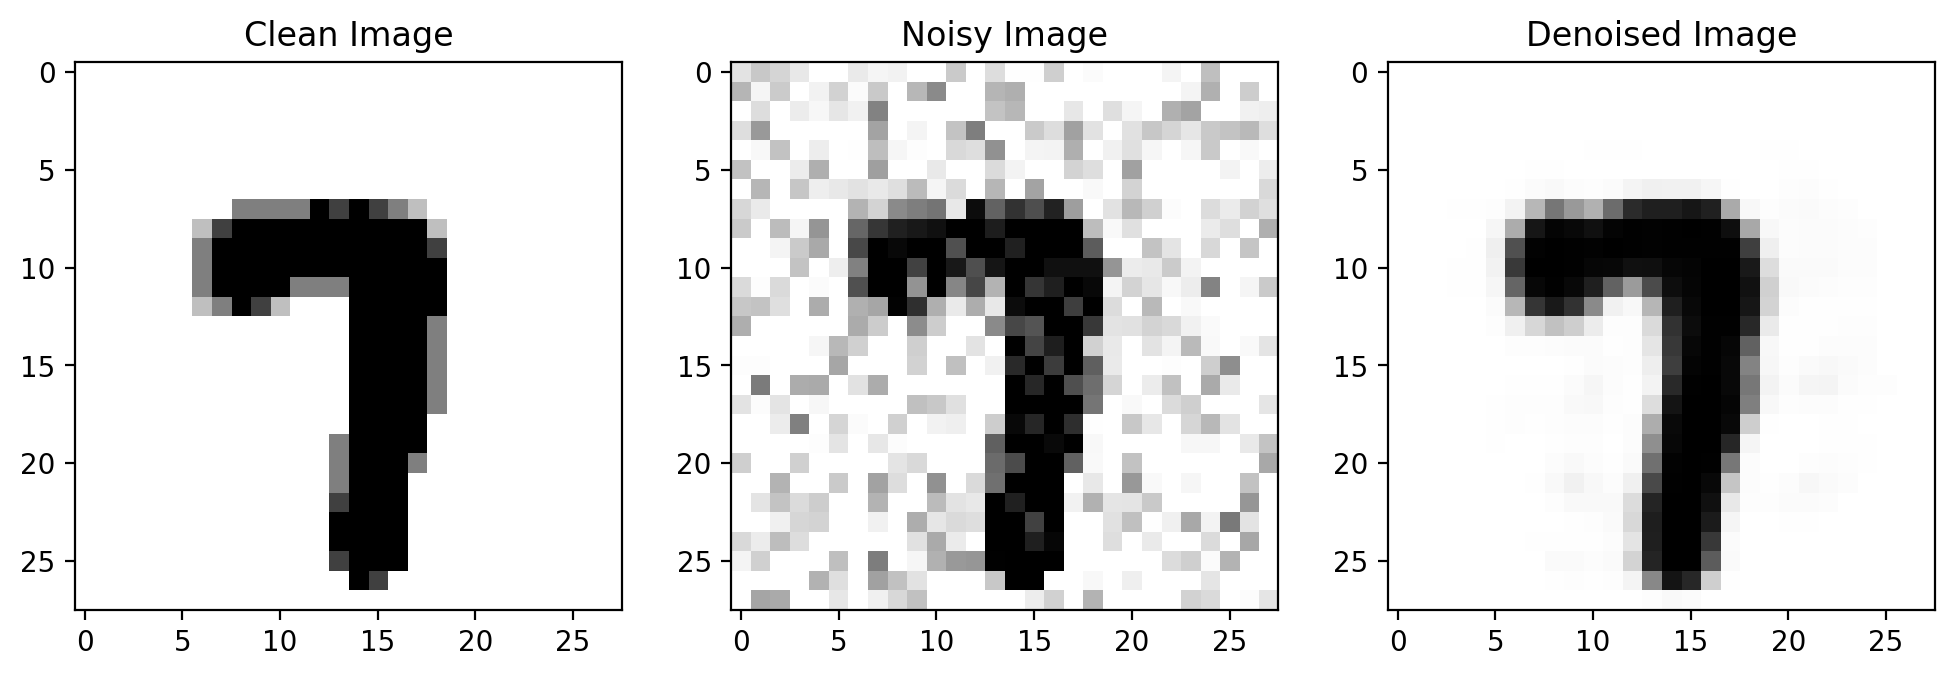

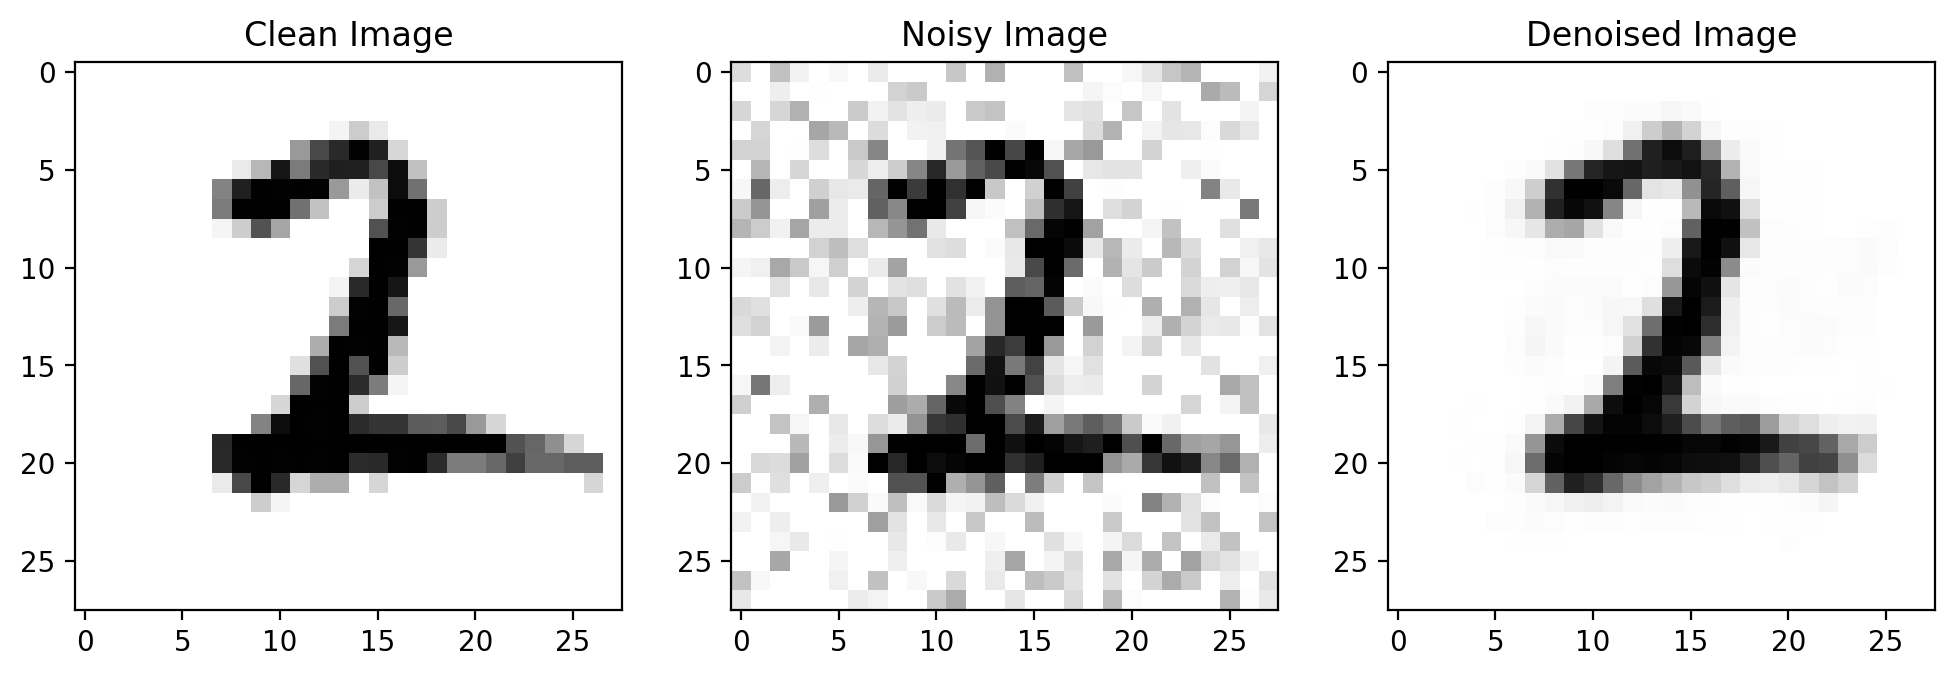

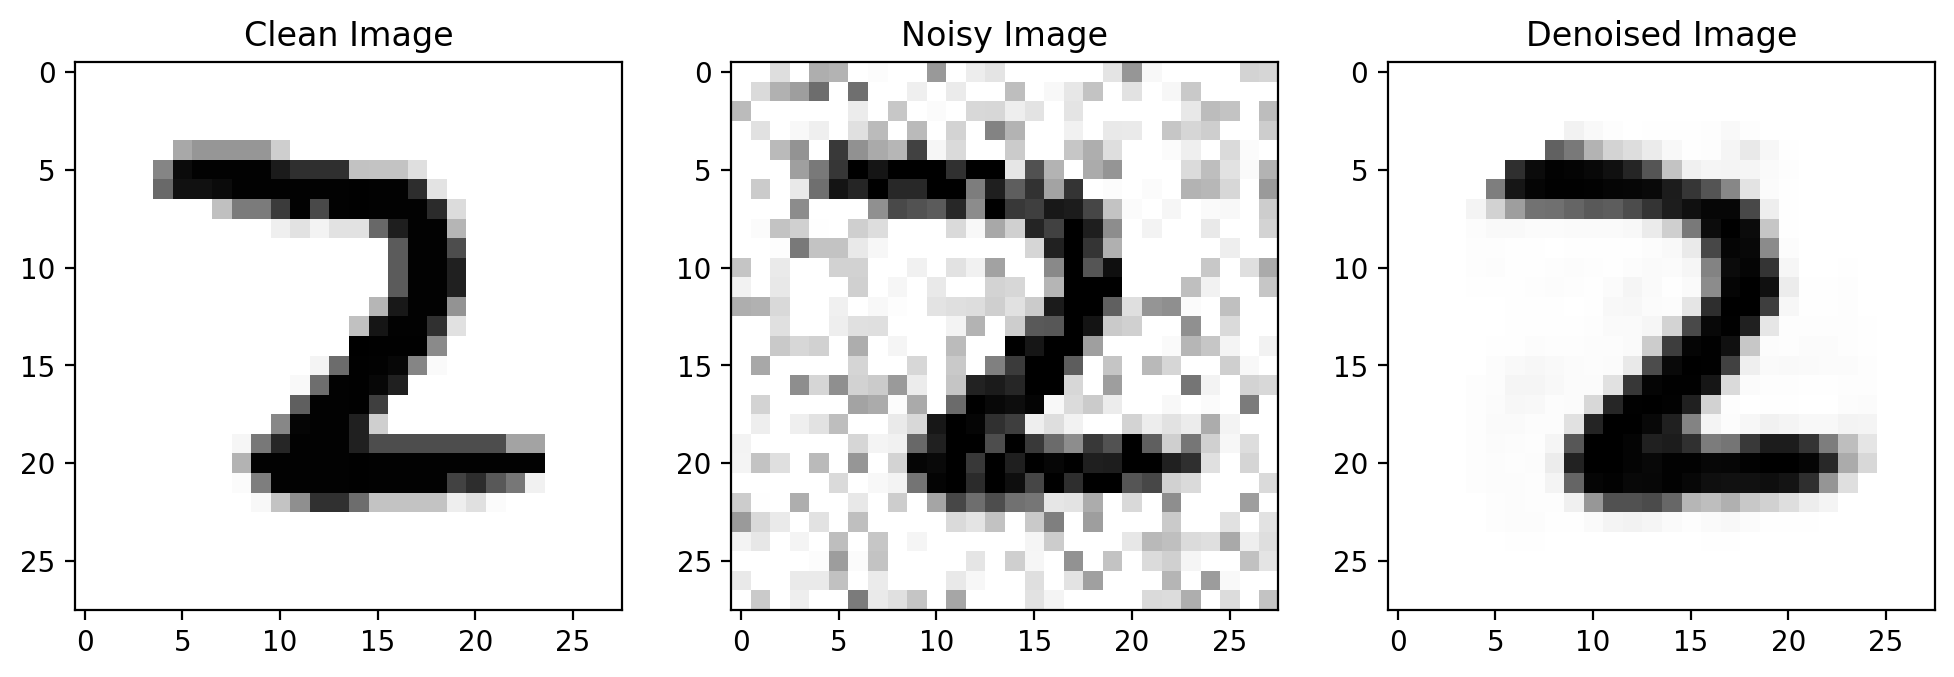

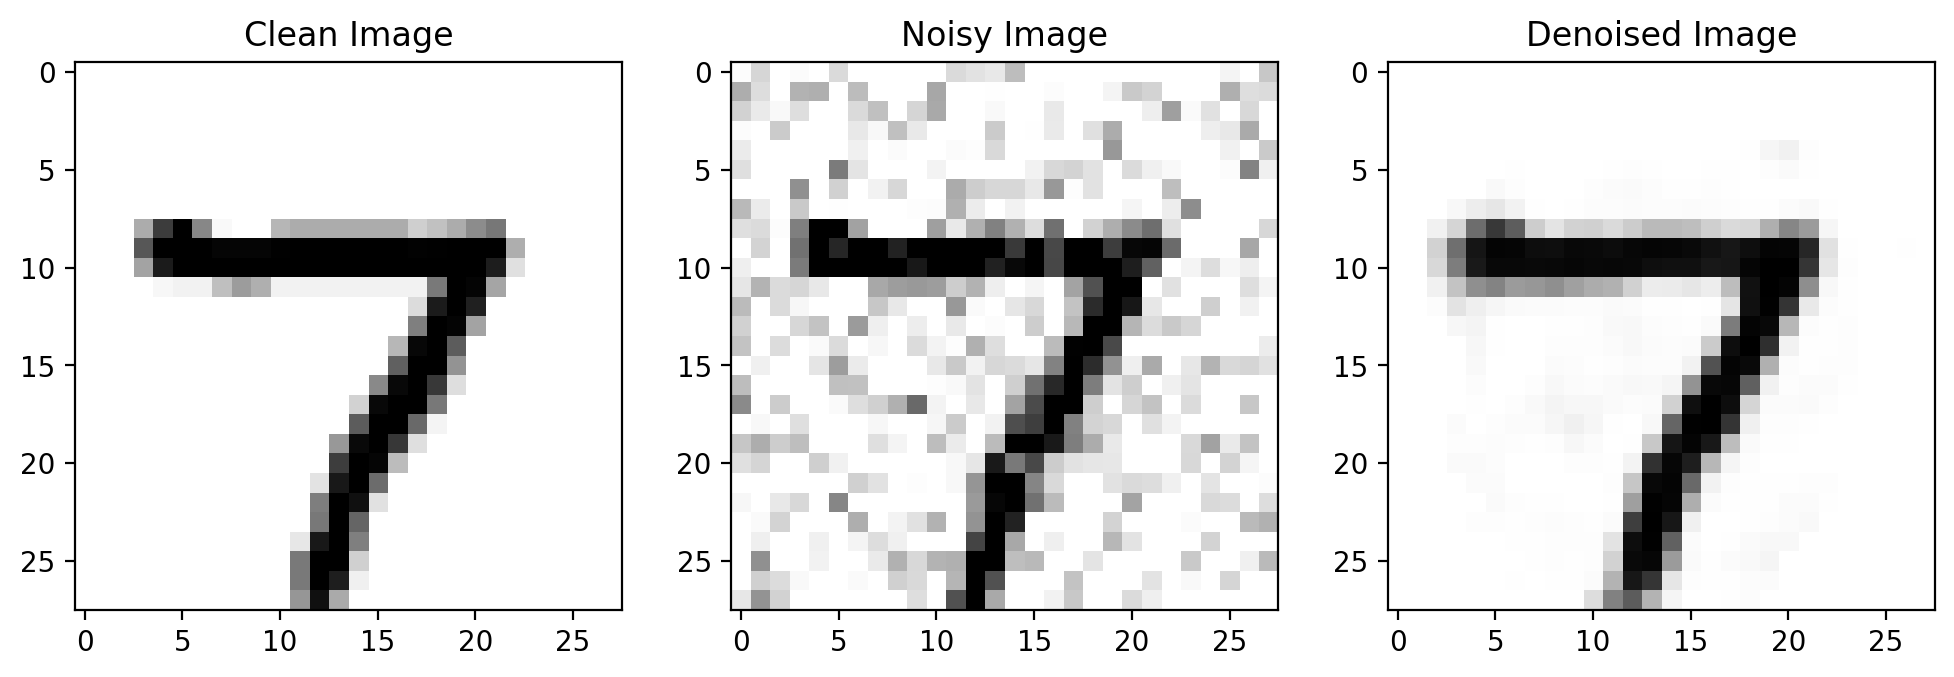

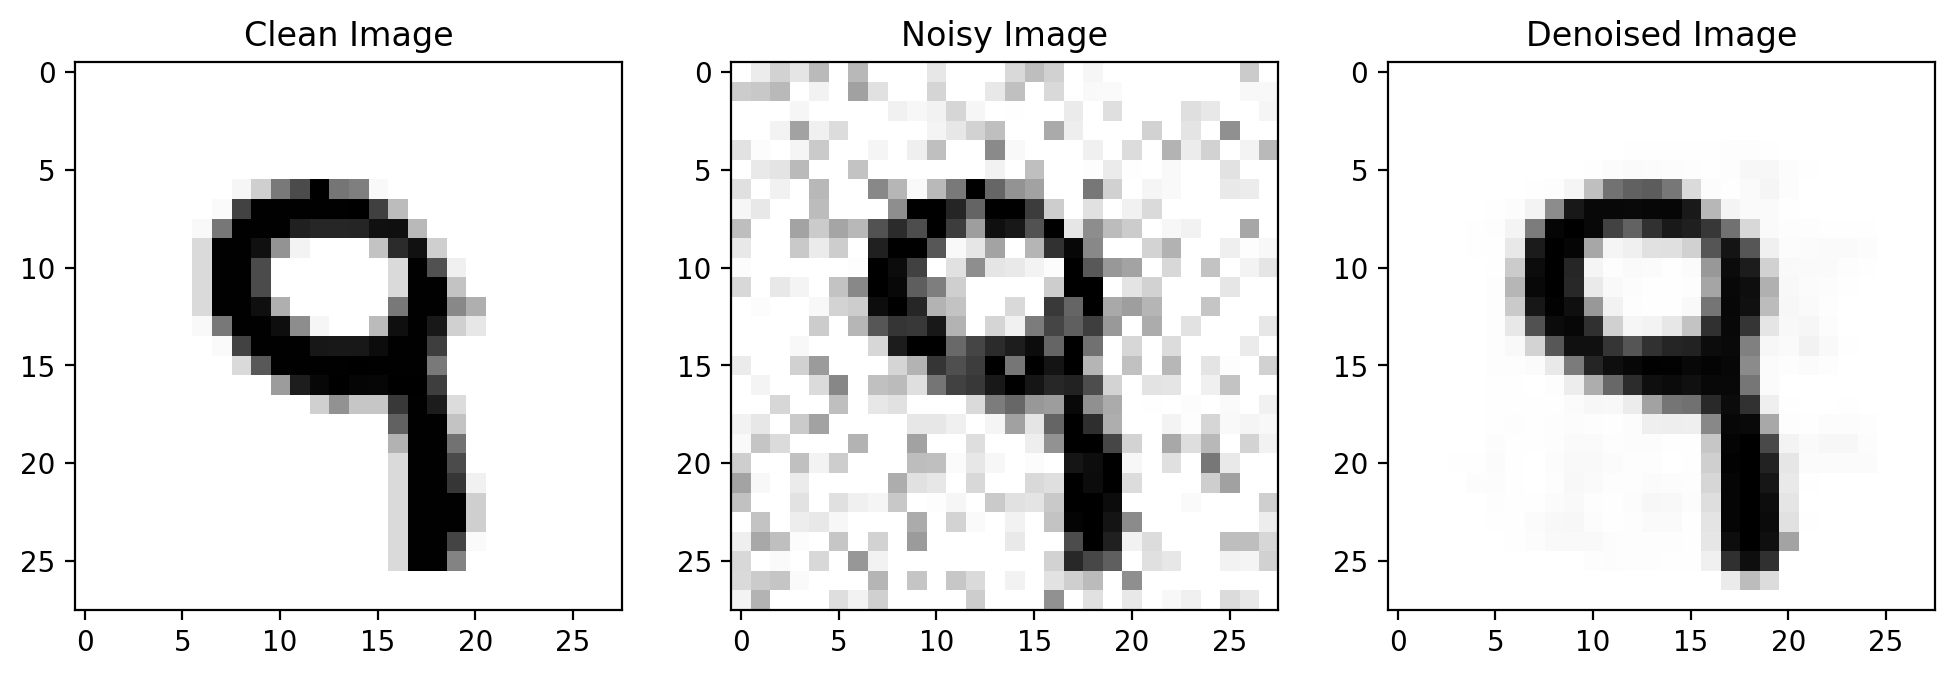

In [124]:
for i in [1, 3, 10, 15, 112]:
    plot_check(i, test_clean_X, test_noisy_X, test_denoised_X)

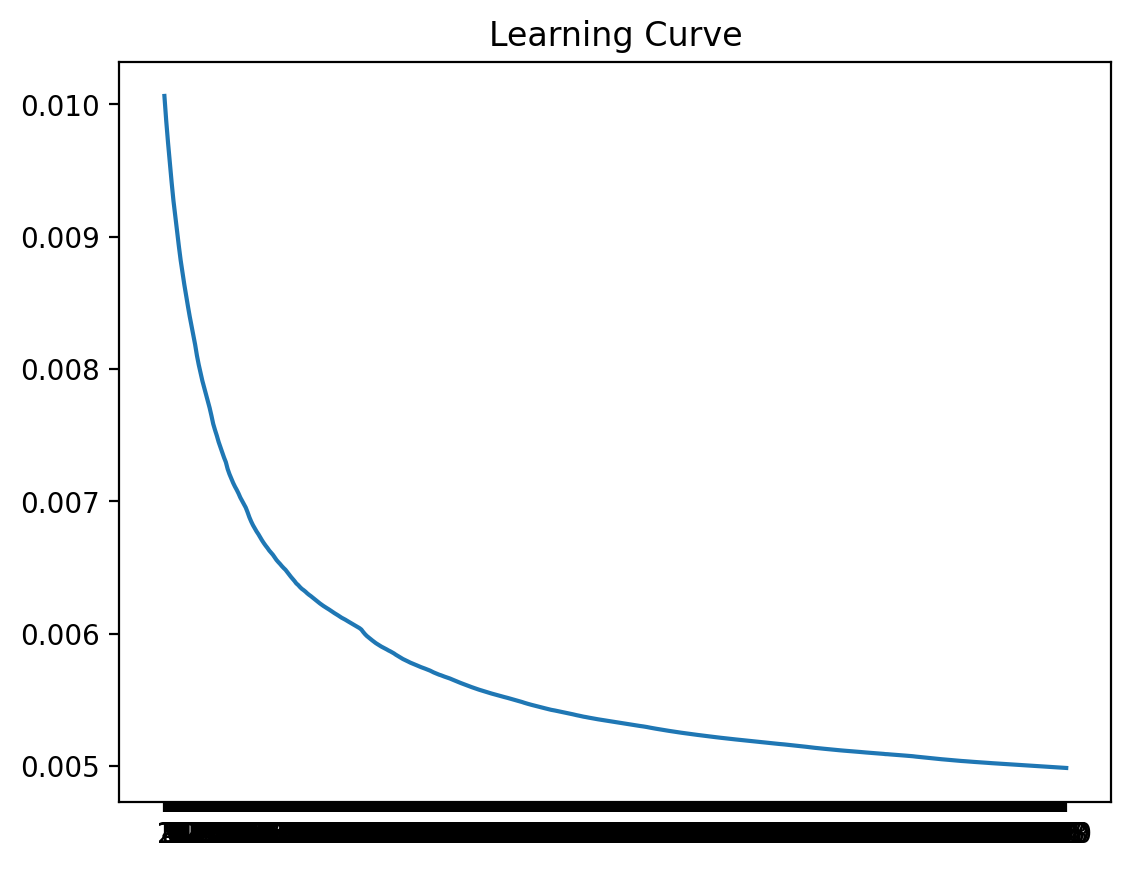

In [125]:
# The fit method returns a history object that
# can be used to plot the learning curve.
def plot_learning_curve(history):
    learning_curve = pd.Series(history.history['loss'])
    learning_curve.index = learning_curve.index + 1

    learning_curve.plot(title='Learning Curve')
    plt.xticks(learning_curve.index)
    plt.show()
    
plot_learning_curve(history)

In [126]:
import os 

model_path = 'assignment_submission'

os.makedirs(model_path, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_path}/score_denoised_x.parquet')

save_model(autoencoder, model_path)

# You now have the following files to be uploaded:
# 1. This notebook and any other Python code you used to train the final model.
# 2. architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset